In [2]:
import os
import cv2
import numpy as np

DATA_DIR = "flowers"
IMG_SIZE = 128


X = []
y = []

label_map = {
    "daisy": 0,
    "dandelion": 1,
    "rose": 2,
    "sunflower": 3,
    "tulip": 4
}
# 這邊是把圖片變成向量 就類似csv
for label_name, label in label_map.items():
    folder = os.path.join(DATA_DIR, label_name)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 這邊可以變成灰階
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # 這邊是用來變成128*128
        X.append(img.flatten())   # 128×128 → 16384
        y.append(label)

# 這邊把它變成numpy
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(4317, 16384) (4317,)


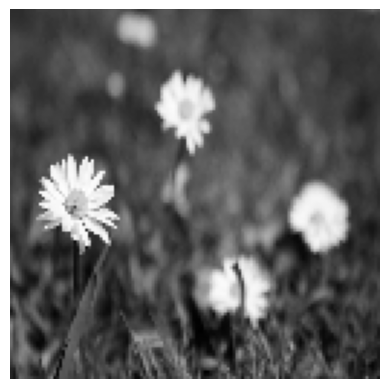

花朵編號： 0


In [3]:
# 會發現多一個因為是欄位名裡面是 0 1 2 3 4 5 6 
# 所以要用掉
import matplotlib.pyplot as plt
import numpy as np
image = X[100,:].reshape(128,128)
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()
print('花朵編號：' , y[100])


原始資料維度: (4317, 16384)
開始進行 PCA...
PCA 後維度: (4317, 4201)
開始進行 LDA...
LDA 後維度: (4317, 4)


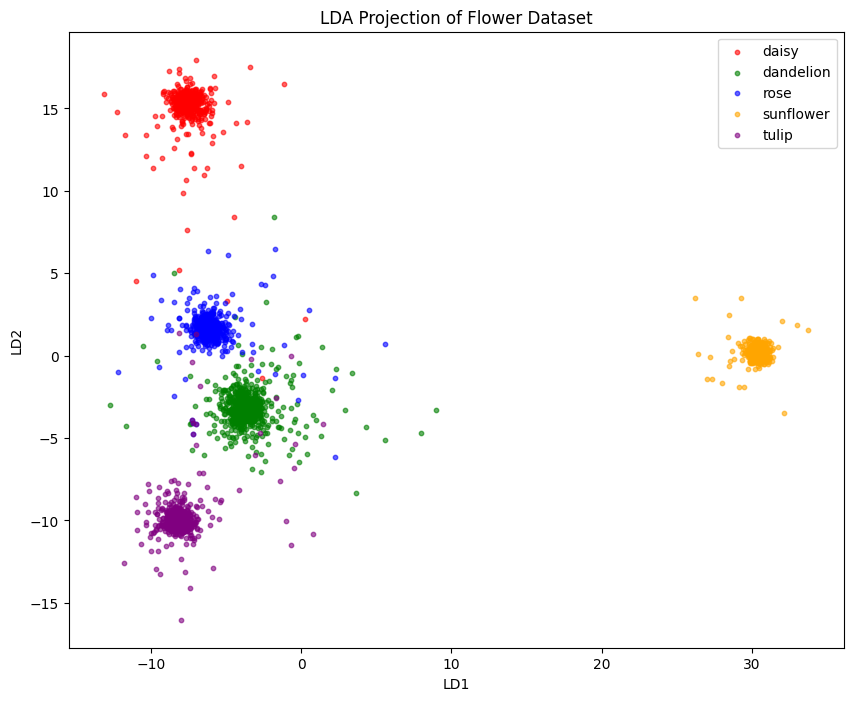

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# --- 假設您已經跑完上面的讀圖程式碼，擁有 X 和 y ---
# X.shape 應該是 (樣本數, 16384)
# y.shape 應該是 (樣本數,)

print(f"原始資料維度: {X.shape}")

# 1. 資料切割 (建議先切分，避免測試集汙染，這裡先用全資料示範流程)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 標準化 (Standardization)
# 影像像素通常是 0-255，做 PCA/LDA 前建議標準化或至少 /255.0


# 3. PCA 降維 (前置作業)
# 設定 n_components=0.95 代表保留 95% 的變異量，通常會把 16384 降到幾百維
print("開始進行 PCA...")
pca = PCA(n_components=0.9999)
X_pca = pca.fit_transform(X)
print(f"PCA 後維度: {X_pca.shape}") 

# 4. LDA 降維 (核心步驟)
# 類別數有 5 (Daisy, Dandelion, Rose, Sunflower, Tulip)
# 所以 LDA 最多只能降到 5-1 = 4 維
print("開始進行 LDA...")
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_pca, y)

print(f"LDA 後維度: {X_lda.shape}") 
# 預期結果: (樣本數, 4)

# --- 視覺化 (選前兩個維度畫圖) ---
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple']
target_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

for i, color, target_name in zip(range(5), colors, target_names):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=0.6, c=color, label=target_name, s=10)

plt.legend(loc='best')
plt.title('LDA Projection of Flower Dataset')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()

In [5]:
# 1. 解釋變異量比率
print("解釋變異量 (Explained Variance Ratio):")
print(lda.explained_variance_ratio_)
# 如果第一個值是 0.95，代表第一軸就解釋了 95% 的區別資訊，分得非常好。

解釋變異量 (Explained Variance Ratio):
[0.57429223 0.1965402  0.14069203 0.08847554]


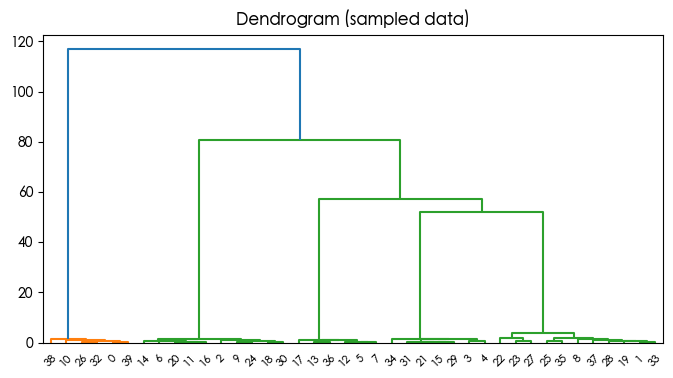

In [6]:
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Heiti TC'  # 或 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False   # 解決負號顯示成方框

import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

idx = np.random.choice(len(X_lda), size=40, replace=False)

linked_sub = linkage(X_lda[idx], method='ward')

plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=None   # 先畫完整樹
)
plt.title("Dendrogram (sampled data)")
plt.show()


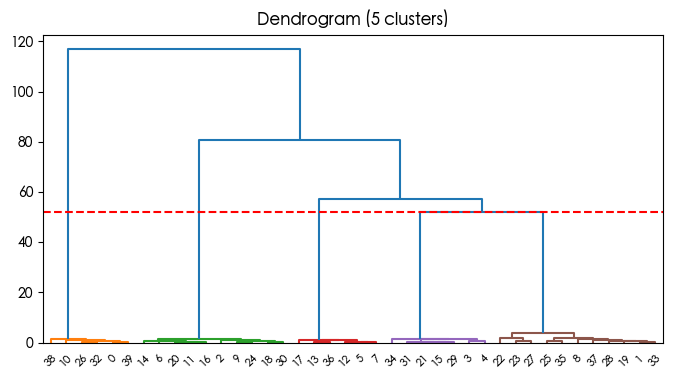

In [7]:
plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=linked_sub[-4, 2]  # 關鍵這一行
)
plt.title("Dendrogram (5 clusters)")
cut_height = linked_sub[-4, 2]
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.show()


In [8]:
from scipy.cluster.hierarchy import linkage

linked = linkage(X_lda, method='ward')
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linked, t=5, criterion='maxclust')

print(cluster_labels.shape)  # (4317,)
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)



(4317,)
Adjusted Rand Index (ARI): 0.9746208337606512


In [9]:
import pandas as pd

ct = pd.crosstab(
    cluster_labels,
    y,
    rownames=["Cluster"],
    colnames=["True Label"]
)

print(ct)


True Label    0     1    2    3    4
Cluster                             
1             0     0    0  733    0
2           756     0    0    0    0
3             0     0  771    0    0
4             0     0    0    0  965
5             8  1052   13    0   19


In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=20
)

kmeans_labels = kmeans.fit_predict(X_lda)


In [11]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print("KMeans ARI:", ari_kmeans)


KMeans ARI: 0.9869955711922942


In [12]:
import pandas as pd

ct_kmeans = pd.crosstab(
    kmeans_labels,
    y,
    rownames=["KMeans Cluster"],
    colnames=["True Label"]
)

print(ct_kmeans)


True Label        0     1    2    3    4
KMeans Cluster                          
0                 2  1050    5    0    7
1                 0     0    0  733    0
2               762     1    1    0    0
3                 0     1    1    0  974
4                 0     0  777    0    3


In [13]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(
    n_clusters=5,
    metric="euclidean",
    random_state=42,
    method="pam"
)

kmedoids_labels = kmedoids.fit_predict(X_lda)


In [14]:
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)
print("KMedoids ARI:", ari_kmedoids)


KMedoids ARI: 0.9869955711922942


In [15]:
ct_kmedoids = pd.crosstab(
    kmedoids_labels,
    y,
    rownames=["KMedoids Cluster"],
    colnames=["True Label"]
)

print(ct_kmedoids)


True Label          0     1    2    3    4
KMedoids Cluster                          
0                   0     0    0  733    0
1                   0     1    1    0  974
2                   0     0  777    0    3
3                   2  1050    5    0    7
4                 762     1    1    0    0


In [16]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=5,        # 這個要調
    min_samples=10  # 常見 5~20
)

db_labels = dbscan.fit_predict(X_lda)


In [17]:
import numpy as np

unique_labels = np.unique(db_labels)
print("Unique cluster labels:", unique_labels)

n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(db_labels == -1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)


Unique cluster labels: [-1  0  1  2  3  4]
Number of clusters: 5
Number of noise points: 35


In [18]:
from sklearn.metrics import adjusted_rand_score

ari_dbscan = adjusted_rand_score(y, db_labels)
print("DBSCAN ARI:", ari_dbscan)


DBSCAN ARI: 0.9793351925537895


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. 修正切分比例：確保 train 是大份的 (test_size=0.2 表示 20% 當測試)
X_train_lda, X_test_lda, y_train, y_test = train_test_split(
    X_lda, y, test_size=0.2, random_state=42, stratify=y
)



# 4. Logistic Regression
# 修正警告：新版 sklearn 建議不需特別指定 multi_class，預設就是 auto/multinomial
logistic = LogisticRegression(
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

logistic.fit(X_train_lda, y_train)
y_pred = logistic.predict(X_test_lda)

# 5. 再次檢查結果
print(f"Train Data Shape: {X_train_lda.shape} (應該要比較大)")
print(f"Test Data Shape: {X_test_lda.shape} (應該要比較小)")
print("-" * 30)
print("New Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Train Data Shape: (3453, 4) (應該要比較大)
Test Data Shape: (864, 4) (應該要比較小)
------------------------------
New Accuracy: 0.9965277777777778

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      0.99      0.99       210
           2       0.99      1.00      1.00       157
           3       1.00      1.00      1.00       147
           4       0.99      0.99      0.99       197

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864



- 可以發現這邊準確度有很高的上升

In [20]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=20
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(
            n_neighbors=k
        ))
    ])

    scores = cross_val_score(
        pipe,
        X_train_lda,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean()}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.9904419136307387
k= 3, Accuracy=0.992179366177982
k= 5, Accuracy=0.9933375280521825
k= 7, Accuracy=0.9924692212504457
k= 9, Accuracy=0.9927590763229095
k=11, Accuracy=0.9924688017785609
k=13, Accuracy=0.9930476729797185
k=15, Accuracy=0.9933371085802974
k=17, Accuracy=0.9933371085802974
k=19, Accuracy=0.9930476729797185
Best k = 5


In [21]:
# 做knn 這邊k = 1
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
    ))
])


final_pipe.fit(X_train_lda, y_train)


y_pred = final_pipe.predict(X_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")



------------------------------
測試集 (Test Set) 辨識正確率: 0.9953703703703703


In [22]:
import pandas as pd

df = pd.DataFrame(
    X_lda,
    columns=[f"PC{i+1}" for i in range(X_lda.shape[1])]
)

# 群組一定要是類別（字串最保險）
df["group"] = y.astype(str)

df.head()


,PC1,PC2,PC3,PC4,group
0,-7.599312,15.782185,6.488448,1.018147,0
1,-6.343347,14.934137,7.218893,0.474365,0
2,-7.831212,15.714671,6.181991,0.823219,0
3,-6.979441,15.311366,5.543511,1.046356,0
4,-7.360663,16.037621,6.773115,0.866319,0


In [23]:
from statsmodels.multivariate.manova import MANOVA

formula = "PC1 + PC2 + PC3 + PC4 ~ group"
maov = MANOVA.from_formula(formula, data=df)
print(maov.mv_test())



                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
           Intercept         Value  Num DF   Den DF   F Value   Pr > F
----------------------------------------------------------------------
              Wilks' lambda  0.0170 4.0000 4309.0000 62371.3066 0.0000
             Pillai's trace  0.9830 4.0000 4309.0000 62371.3066 0.0000
     Hotelling-Lawley trace 57.8986 4.0000 4309.0000 62371.3066 0.0000
        Roy's greatest root 57.8986 4.0000 4309.0000 62371.3066 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
         group           Value    Num DF   Den DF     F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda   0.0